In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (168/168), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 339 (delta 96), reused 80 (delta 62), pack-reused 171
Receiving objects: 100% (339/339), 55.24 MiB | 12.45 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=25374 sha256=34872cea0f02e7cbf83cede4c42bfefbfc6da6d9e615092e226e6d2a76523b3e
  Stored in directory: /tmp/pip-ephem-wheel-cache-3c_ocfau/wheels/55/59/29/0fb1c63565215

In [2]:
from dul_2021.utils.hw10_utils import *

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [63]:
# curl http://localhost:5001/api/code_search/check_project/ --header "Content-Type: application/json" --request POST --data '{"project_name":"meow"}'


import torch
import torch.nn.functional as F
from itertools import chain
from torch import nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import numpy as np
from typing import Tuple

import torch
from torch.utils.data import Dataset


class ContextDataset(Dataset):
    _img_h, _img_w = 28, 28
    _crop_h, _crop_w = 14, 14

    def __init__(self, data):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # [1; h; w]
        image, _ = self._data[idx]
        # [1; h; w]
        mask = self.get_mask()
        target = image[mask].reshape(-1, self._crop_h, self._crop_w)
        image[mask] = 0
        return image, target

    @classmethod
    def get_mask(cls):
        mask = torch.zeros((1, cls._img_h, cls._img_w), dtype=torch.bool)
        h_c, w_c = cls._img_h // 2, cls._img_w // 2
        h_p, w_p = cls._crop_h // 2, cls._crop_w // 2
        mask[:, h_c - h_p: h_c + h_p, w_c - w_p: w_c + w_p] = True
        return mask

from copy import deepcopy

def create_mask(images_b, crop_height=14, crop_width=14):
    print(images_b.shape)
    tg=deepcopy(images_b)
    for i, images in enumerate(images_b):
        # images=images_b[i]
        mask = torch.zeros((1, 28, 28), dtype=torch.bool)
        h_c, w_c = 28 // 2, 28 // 2
        h_p, w_p = 28 // 2, 28 // 2
        mask[:, h_c - h_p: h_c + h_p, w_c - w_p: w_c + w_p] = True
        target = images[mask].reshape(-1, crop_height, crop_width)
        images[mask] = 0
        tg[i]=target
        images_b[i]=images

    return images_b, target

    # img = []
    # tg = []
    # for image in images:
    #     mask = torch.zeros((1, 28, 28), dtype=torch.bool)
    #     h_c, w_c = 28 // 2, 28 // 2
    #     h_p, w_p = 28 // 2, 28 // 2
    #     mask[:, h_c - h_p: h_c + h_p, w_c - w_p: w_c + w_p] = True
    #     target = image[mask].reshape(-1, crop_height, crop_width)
    #     image[mask] = 0
    #     img.append(image)
    #     tg.append(target)
    # img = np.asarray(img)
    # tg = np.asarray(tg)
    # return torch.from_numpy(img), torch.from_numpy(tg)


class DenoisingBlock(nn.Module):
    def __init__(
            self,
            in_ch: int,
            out_ch: int,
            stride: int = 1,
            bias: bool = False,
            upsample: bool = False,
            lr_cf: float = 0.2,
            dropout: float = 0.3,
    ):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_ch, out_ch, (3, 3), stride=stride, padding=1, bias=bias)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.LeakyReLU(lr_cf)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False, recompute_scale_factor=False)
        x = x + torch.randn_like(x) * 0.05
        x = self.dropout(x)
        return self.act(self.norm(self.conv(x)))


class MaskedImageEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()

        self.blocks = nn.Sequential(
            DenoisingBlock(1, 16, stride=2),  # [1; 28; 28] -> [16; 14; 14]
            DenoisingBlock(16, 32, stride=2),  # [16; 14; 14] -> [32; 7; 7]
            DenoisingBlock(32, 64, stride=2),  # [32; 7; 7] -> [64; 4; 4]
            DenoisingBlock(64, 128, stride=2),  # [64; 4; 4] -> [128; 2; 2]
            DenoisingBlock(128, 128, stride=2).conv,  # [128; 2; 2] -> [128; 1; 1]
        )
        self.linear = nn.Linear(128, latent_dim)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        convolved = self.blocks(images)
        return self.linear(convolved.view(images.shape[0], -1))


class PatchDecoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.linear = nn.Linear(latent_dim, 128 * 2 * 2)
        self.blocks = nn.Sequential(
            DenoisingBlock(128, 64, upsample=True),  # [128; 2; 2] -> [64; 4; 4]
            DenoisingBlock(64, 32, upsample=True),  # [64; 4; 4] -> [32; 8; 8]
            DenoisingBlock(32, 16, upsample=True),  # [32; 8; 8] -> [16; 16; 16]
            nn.Conv2d(16, 1, kernel_size=(3, 3)),  # [16; 16; 16] -> [1; 14; 14]
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        sized = self.linear(images)
        sized = sized.view(-1, 128, 2, 2)
        decoded = self.blocks(sized)
        return torch.tanh(decoded)


class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.blocks = nn.Sequential(
            DenoisingBlock(1, 16, stride=2),  # [1; 14; 14] -> [16; 7; 7]
            DenoisingBlock(16, 32, stride=2),  # [16; 7; 7] -> [32; 7; 7]
            DenoisingBlock(32, 64, stride=2),  # [32; 4; 4] -> [64; 2; 2]
            DenoisingBlock(64, 128, stride=2),  # [64; 2; 2] -> [128; 1; 1]
        )
        self.linear = nn.Linear(128, 1)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        convolved = self.blocks(images)
        logit = self.linear(convolved.view(images.shape[0], -1))
        return torch.sigmoid(logit)


class ContextEncoder:
    def __init__(self, latent_dim: int, device: torch.device):
        self.encoder = MaskedImageEncoder(latent_dim).to(device)
        self.decoder = PatchDecoder(latent_dim).to(device)
        self.discriminator = PatchDiscriminator().to(device)
        self.device = device

    def _train_epoch(self, train_dataloader: DataLoader, ed_optim: Optimizer, d_optim: Optimizer):
        self.encoder.train()
        self.decoder.train()
        self.discriminator.train()

        rec_losses = []
        adv_losses = []
        postfix = {}
        data_pbar = tqdm(train_dataloader, leave=False, desc="Training", postfix=postfix)
        for images in data_pbar:
            images, patches = create_mask(images)
            images = images.to(self.device)
            patches = patches.to(self.device)
            bs = images.shape[0]

            with torch.no_grad():
                embeddings = self.encoder(images)
                reconstruction = self.decoder(embeddings)

            real_patches = self.discriminator(patches)
            fake_patches = self.discriminator(reconstruction)

            adv_loss = F.binary_cross_entropy(real_patches, torch.ones((bs, 1), device=self.device))
            adv_loss += F.binary_cross_entropy(fake_patches, torch.zeros((bs, 1), device=self.device))

            d_optim.zero_grad()
            adv_loss.backward()
            d_optim.step()

            embeddings = self.encoder(images)
            reconstruction = self.decoder(embeddings)
            mse_loss = F.mse_loss(reconstruction, patches)

            ed_optim.zero_grad()
            mse_loss.backward()
            ed_optim.step()

            adv_losses.append(adv_loss.item())
            rec_losses.append(mse_loss.item())
            postfix = {"mse": rec_losses[-1], "adv": adv_losses[-1]}
            data_pbar.set_postfix(postfix)
        data_pbar.close()

        return rec_losses, adv_losses

    def train(self, train_dataloader: DataLoader, n_epochs: int, lr: float):
        ed_optim = torch.optim.AdamW(chain(self.encoder.parameters(), self.decoder.parameters()), lr=lr)
        d_optim = torch.optim.AdamW(self.discriminator.parameters(), lr=lr)

        rec_losses = []
        adv_losses = []

        epoch_bar = trange(n_epochs, desc="Epochs")
        for _ in epoch_bar:
            epoch_rec_loss, epoch_adv_losses = self._train_epoch(train_dataloader, ed_optim, d_optim)
            rec_losses += epoch_rec_loss
            adv_losses += epoch_adv_losses
        epoch_bar.close()
        return rec_losses, adv_losses

    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.discriminator.eval()


In [78]:


import torch
import torch.nn.functional as F
from itertools import chain
from torch import nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
import numpy as np
from typing import Tuple

import torch
from torch.utils.data import Dataset

from copy import deepcopy

def create_mask(images_b, crop_height=14, crop_width=14):
    print(images_b.shape)
    tg=torch.zeros((images_b.shape[0], 14, 14))
    for i, images in enumerate(images_b):
        mask = torch.zeros((1, 28, 28), dtype=torch.bool)
        h_c, w_c = 28 // 2, 28 // 2
        h_p, w_p = 14 // 2, 14 // 2
        mask[:, h_c - h_p: h_c + h_p, w_c - w_p: w_c + w_p] = True
        target = images[mask].reshape(-1, crop_height, crop_width)
        images[mask] = 0
        tg[i]=target
        images_b[i]=images
    return images_b, tg



class DenoisingBlock(nn.Module):
    def __init__(
            self,
            in_ch: int,
            out_ch: int,
            stride: int = 1,
            bias: bool = False,
            upsample: bool = False,
            lr_cf: float = 0.2,
            dropout: float = 0.3,
    ):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_ch, out_ch, (3, 3), stride=stride, padding=1, bias=bias)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.LeakyReLU(lr_cf)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        if self.upsample:
            x = F.interpolate(x, scale_factor=2, mode="bilinear", align_corners=False, recompute_scale_factor=False)
        x = x + torch.randn_like(x) * 0.05
        x = self.dropout(x)
        return self.act(self.norm(self.conv(x)))


class MaskedImageEncoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()

        self.blocks = nn.Sequential(
            DenoisingBlock(1, 16, stride=2),  # [1; 28; 28] -> [16; 14; 14]
            DenoisingBlock(16, 32, stride=2),  # [16; 14; 14] -> [32; 7; 7]
            DenoisingBlock(32, 64, stride=2),  # [32; 7; 7] -> [64; 4; 4]
            DenoisingBlock(64, 128, stride=2),  # [64; 4; 4] -> [128; 2; 2]
            DenoisingBlock(128, 128, stride=2).conv,  # [128; 2; 2] -> [128; 1; 1]
        )
        self.linear = nn.Linear(128, latent_dim)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        convolved = self.blocks(images)
        return self.linear(convolved.view(images.shape[0], -1))


class PatchDecoder(nn.Module):
    def __init__(self, latent_dim: int):
        super().__init__()
        self.linear = nn.Linear(latent_dim, 128 * 2 * 2)
        self.blocks = nn.Sequential(
            DenoisingBlock(128, 64, upsample=True),  # [128; 2; 2] -> [64; 4; 4]
            DenoisingBlock(64, 32, upsample=True),  # [64; 4; 4] -> [32; 8; 8]
            DenoisingBlock(32, 16, upsample=True),  # [32; 8; 8] -> [16; 16; 16]
            nn.Conv2d(16, 1, kernel_size=(3, 3)),  # [16; 16; 16] -> [1; 14; 14]
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        sized = self.linear(images)
        sized = sized.view(-1, 128, 2, 2)
        decoded = self.blocks(sized)
        return torch.tanh(decoded)


class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.blocks = nn.Sequential(
            DenoisingBlock(1, 16, stride=2),  # [1; 14; 14] -> [16; 7; 7]
            DenoisingBlock(16, 32, stride=2),  # [16; 7; 7] -> [32; 7; 7]
            DenoisingBlock(32, 64, stride=2),  # [32; 4; 4] -> [64; 2; 2]
            DenoisingBlock(64, 128, stride=2),  # [64; 2; 2] -> [128; 1; 1]
        )
        self.linear = nn.Linear(128, 1)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        convolved = self.blocks(images)
        logit = self.linear(convolved.view(images.shape[0], -1))
        return torch.sigmoid(logit)


class ContextEncoder:
    def __init__(self, latent_dim: int, device: torch.device):
        self.encoder = MaskedImageEncoder(latent_dim).to(device)
        self.decoder = PatchDecoder(latent_dim).to(device)
        self.discriminator = PatchDiscriminator().to(device)
        self.device = device

    def _train_epoch(self, train_dataloader: DataLoader, ed_optim: Optimizer, d_optim: Optimizer):
        self.encoder.train()
        self.decoder.train()
        self.discriminator.train()

        rec_losses = []
        adv_losses = []
        postfix = {}
        data_pbar = tqdm(train_dataloader, leave=False, desc="Training", postfix=postfix)
        for images in data_pbar:
            images, patches = create_mask(images)
            images = images.to(self.device)
            patches = patches.to(self.device)
            bs = images.shape[0]

            with torch.no_grad():
                embeddings = self.encoder(images)
                reconstruction = self.decoder(embeddings)

            real_patches = self.discriminator(patches)
            fake_patches = self.discriminator(reconstruction)

            adv_loss = F.binary_cross_entropy(real_patches, torch.ones((bs, 1), device=self.device))
            adv_loss += F.binary_cross_entropy(fake_patches, torch.zeros((bs, 1), device=self.device))

            d_optim.zero_grad()
            adv_loss.backward()
            d_optim.step()

            embeddings = self.encoder(images)
            reconstruction = self.decoder(embeddings)
            mse_loss = F.mse_loss(reconstruction, patches)

            ed_optim.zero_grad()
            mse_loss.backward()
            ed_optim.step()

            adv_losses.append(adv_loss.item())
            rec_losses.append(mse_loss.item())
            postfix = {"mse": rec_losses[-1], "adv": adv_losses[-1]}
            data_pbar.set_postfix(postfix)
        data_pbar.close()

        return rec_losses, adv_losses

    def train(self, train_dataloader: DataLoader, n_epochs: int, lr: float):
        ed_optim = torch.optim.AdamW(chain(self.encoder.parameters(), self.decoder.parameters()), lr=lr)
        d_optim = torch.optim.AdamW(self.discriminator.parameters(), lr=lr)

        rec_losses = []
        adv_losses = []

        epoch_bar = trange(n_epochs, desc="Epochs")
        for _ in epoch_bar:
            epoch_rec_loss, epoch_adv_losses = self._train_epoch(train_dataloader, ed_optim, d_optim)
            rec_losses += epoch_rec_loss
            adv_losses += epoch_adv_losses
        epoch_bar.close()
        return rec_losses, adv_losses

    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.discriminator.eval()


In [79]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    
    train_data = train_data.data.unsqueeze(1).float()
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)

    context_encoder = ContextEncoder(10, device)
    mse_losses, adv_losses = context_encoder.train(train_dataloader, n_epochs=1, lr=1e-3)

    return None, None, None

In [80]:
q1_results(q1)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 1, 28, 28])


RuntimeError: ignored

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """

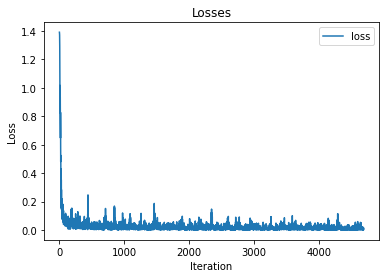

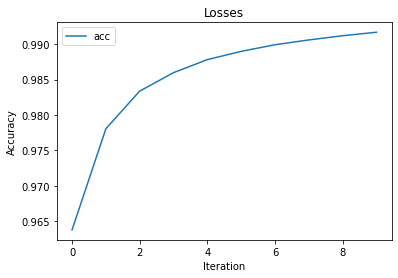

In [ ]:
q2_results(q2)